Imports

In [106]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

Load data

In [107]:
# Load the titles from the CSV file
file_path = 'results_no_head.csv'  # Update the path if needed
# df = pd.read_csv(file_path, header=None, names=['title'])
ala_results = pd.read_csv("results_no_head.csv", header=None, names=['label', 'title'] ,sep=",")
guy_results = pd.read_csv("predictions.csv", header=None, names=['label', 'title'] ,sep=",")
amb_results = pd.read_csv("new_data_amb.csv", header=None, names=['label', 'title', 'process'] ,sep=",")

df = pd.DataFrame({
    'title': ala_results['title'],           # Titles from ala_results (assumed identical across datasets)
    'Aurele model': ala_results['label'],       # Labels from ala_results
    'Guy model': guy_results['label'],       # Labels from guy_results
    'Ambrose model': amb_results['label']      # Labels from the third dataset
})


# Display the first few rows
print(df.head())

                                               title  Aurele model  Guy model  \
0  copycat muslim terrorist arrested with assault...             0          0   
1  wow! chicago protester caught on camera admits...             0          0   
2   germany's fdp look to fill schaeuble's big shoes             1          1   
3  mi school sends welcome back packet warning ki...             0          0   
4  u.n. seeks 'massive' aid boost amid rohingya '...             1          1   

   Ambrose model  
0              0  
1              0  
2              1  
3              0  
4              1  


Preprocess

In [108]:
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

# Download NLTK resources (run this once)
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean and lemmatize the titles
def preprocess(text):
    # Turn into strings
    text = str(text)
    
    # Remove JS/CSS
    text = re.sub(r'<script\b[^<]*(?:(?!<\/script>)<[^<]*)*<\/script>|<style\b[^<]*(?:(?!<\/style>)<[^<]*)*<\/style>', '', text)
    
    # Remove HTML comments
    text = re.sub(r'<!--.*?-->', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove all single characters
    text = re.sub(r'\b[a-zA-Z]\b', '', text)  # Remove isolated single letters
    
    # Remove single characters from the start
    text = re.sub(r'\b[a-zA-Z]\s+', '', text)
    
    # Remove prefixed 'b' (commonly from bytes conversion)
    text = re.sub(r'\bb\b', '', text)
    
    # Substitute multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Lemmatize each word
    text = ' '.join([lemmatizer.lemmatize(word) for word in words])
    
    return text

# Apply preprocessing to the titles
df['clean_title'] = df['title'].apply(preprocess)

# Display the cleaned titles
df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,title,Aurele model,Guy model,Ambrose model,clean_title
0,copycat muslim terrorist arrested with assault...,0,0,0,copycat muslim terrorist arrested with assault...
1,wow! chicago protester caught on camera admits...,0,0,0,wow chicago protester caught on camera admits ...
2,germany's fdp look to fill schaeuble's big shoes,1,1,1,germany fdp look to fill schaeubles big shoe
3,mi school sends welcome back packet warning ki...,0,0,0,mi school sends welcome back packet warning ki...
4,u.n. seeks 'massive' aid boost amid rohingya '...,1,1,1,un seek massive aid boost amid rohingya emerge...


Convert Titles to TF-IDF Vectors

In [109]:
# Convert the titles to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_title'])

# Display the shape of the TF-IDF matrix
print(f"TF-IDF matrix shape: {X.shape}")

TF-IDF matrix shape: (9984, 1000)


Determine the Optimal Number of Clusters

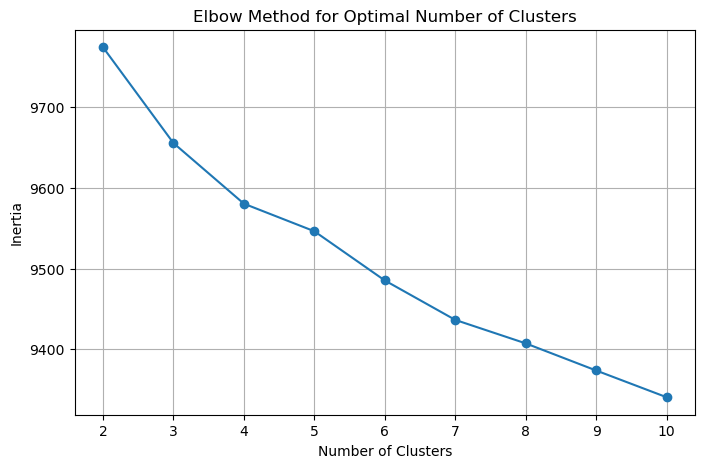

In [110]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Apply K-Means Clustering

In [111]:
# Set the optimal number of clusters (adjust based on the elbow curve)
optimal_clusters = 5

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Display the first few rows with cluster assignments
df.head()

,title,Aurele model,Guy model,Ambrose model,clean_title,cluster
0,copycat muslim terrorist arrested with assault...,0,0,0,copycat muslim terrorist arrested with assault...,4
1,wow! chicago protester caught on camera admits...,0,0,0,wow chicago protester caught on camera admits ...,2
2,germany's fdp look to fill schaeuble's big shoes,1,1,1,germany fdp look to fill schaeubles big shoe,2
3,mi school sends welcome back packet warning ki...,0,0,0,mi school sends welcome back packet warning ki...,2
4,u.n. seeks 'massive' aid boost amid rohingya '...,1,1,1,un seek massive aid boost amid rohingya emerge...,4


Suggest Possible Cluster Names

In [112]:
# Get the feature names from the vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Function to get top keywords for each cluster
def get_top_keywords(X, labels, feature_names, n_words=5):
    top_keywords = {}
    for cluster in set(labels):
        # Get the indices of the titles in this cluster
        indices = np.where(labels == cluster)
        # Compute the mean TF-IDF score for each word in the cluster
        mean_tfidf = X[indices].mean(axis=0)
        # Get the top n words with the highest TF-IDF scores
        top_n_words = feature_names[np.argsort(mean_tfidf)[0, -n_words:]].tolist()
        top_keywords[cluster] = [str(word) for word in top_n_words[::-1]]  # Ensure all are strings
    return top_keywords

# Get the top keywords for each cluster
cluster_keywords = get_top_keywords(X, df['cluster'].values, feature_names, n_words=5)

# Display the possible cluster names
for cluster, keywords in cluster_keywords.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")


Cluster 0: ['north', 'korea', 'say', 'syria', 'russia']
Cluster 1: ['medium', 'social', 'ep', 'room', 'boiler']
Cluster 2: ['police', 'new', 'hillary', 'say', 'video']
Cluster 3: ['donald', 'supporter', 'president', 'video', 'trump']
Cluster 4: ['refugee', 'bangladesh', 'rohingya', 'myanmar', 'muslim']


Sort Titles by Clusters and Save Files

In [113]:
# Add possible cluster names to the DataFrame
df['cluster_name'] = df['cluster'].apply(lambda x: ', '.join(cluster_keywords[x]))

# Sort the DataFrame by clusters
# df_sorted = df.sort_values(by='cluster')

# Save the file with possible cluster names
# df_sorted[['title', 'cluster', 'cluster_name']].to_csv('titles_with_clusters_and_names.csv', index=False)

# Save the file without possible cluster names
df.head()

,title,Aurele model,Guy model,Ambrose model,clean_title,cluster,cluster_name
0,copycat muslim terrorist arrested with assault...,0,0,0,copycat muslim terrorist arrested with assault...,4,"['refugee', 'bangladesh', 'rohingya', 'myanmar..."
1,wow! chicago protester caught on camera admits...,0,0,0,wow chicago protester caught on camera admits ...,2,"['police', 'new', 'hillary', 'say', 'video']"
2,germany's fdp look to fill schaeuble's big shoes,1,1,1,germany fdp look to fill schaeubles big shoe,2,"['police', 'new', 'hillary', 'say', 'video']"
3,mi school sends welcome back packet warning ki...,0,0,0,mi school sends welcome back packet warning ki...,2,"['police', 'new', 'hillary', 'say', 'video']"
4,u.n. seeks 'massive' aid boost amid rohingya '...,1,1,1,un seek massive aid boost amid rohingya emerge...,4,"['refugee', 'bangladesh', 'rohingya', 'myanmar..."


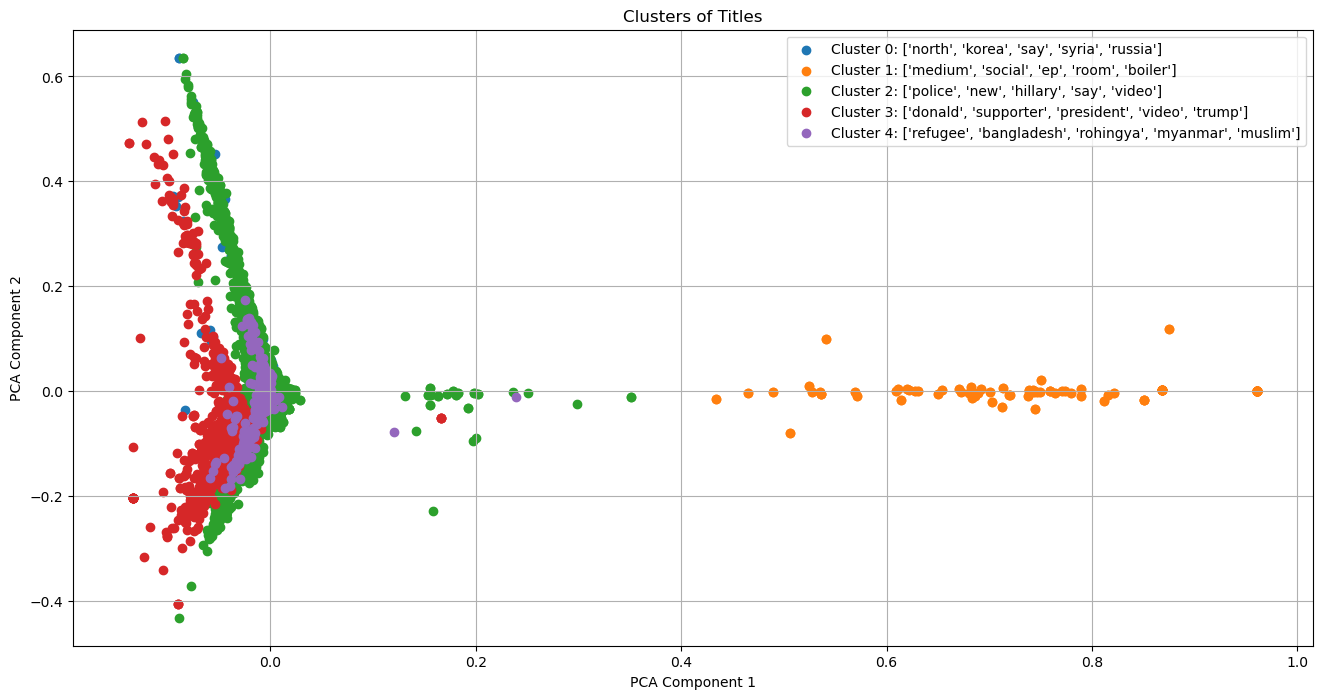

In [146]:
# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(16, 8))
for cluster in set(df['cluster']):
    # Extract the cluster name (assuming all rows in the same cluster have the same cluster_name)
    cluster_label = df[df['cluster'] == cluster]['cluster_name'].iloc[0]
    
    plt.scatter(
        X_pca[df['cluster'] == cluster, 0],
        X_pca[df['cluster'] == cluster, 1],
        label=f'Cluster {cluster}: {cluster_label}'
    )

plt.title('Clusters of Titles')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
# Create a pivot table with counts of 0s and 1s per model and cluster
pivot_table = df.melt(
    id_vars=['cluster'], 
    value_vars=['Aurele model', 'Guy model', 'Ambrose model'], 
    var_name='Model', 
    value_name='Label'
).pivot_table(
    index=['cluster', 'Model'], 
    columns='Label', 
    aggfunc='size', 
    fill_value=0
)

# Rename the columns for clarity
pivot_table.columns = ['Count_0', 'Count_1']

# Display the pivot table
pivot_table.head()

#Create CSV
# pivot_table.to_csv('pivot_table_counts.csv')


Count_0  Count_1
cluster Model                          
0       Ambrose model       31      186
        Aurele model        25      192
        Guy model           31      186
1       Ambrose model       93       96
        Aurele model       149       40

In [140]:
# Count the number of titles per cluster
titles_per_cluster = df.groupby('cluster').size()

# Display the counts
print(titles_per_cluster)

cluster
0     217
1     189
2    7961
3    1205
4     412
dtype: int64


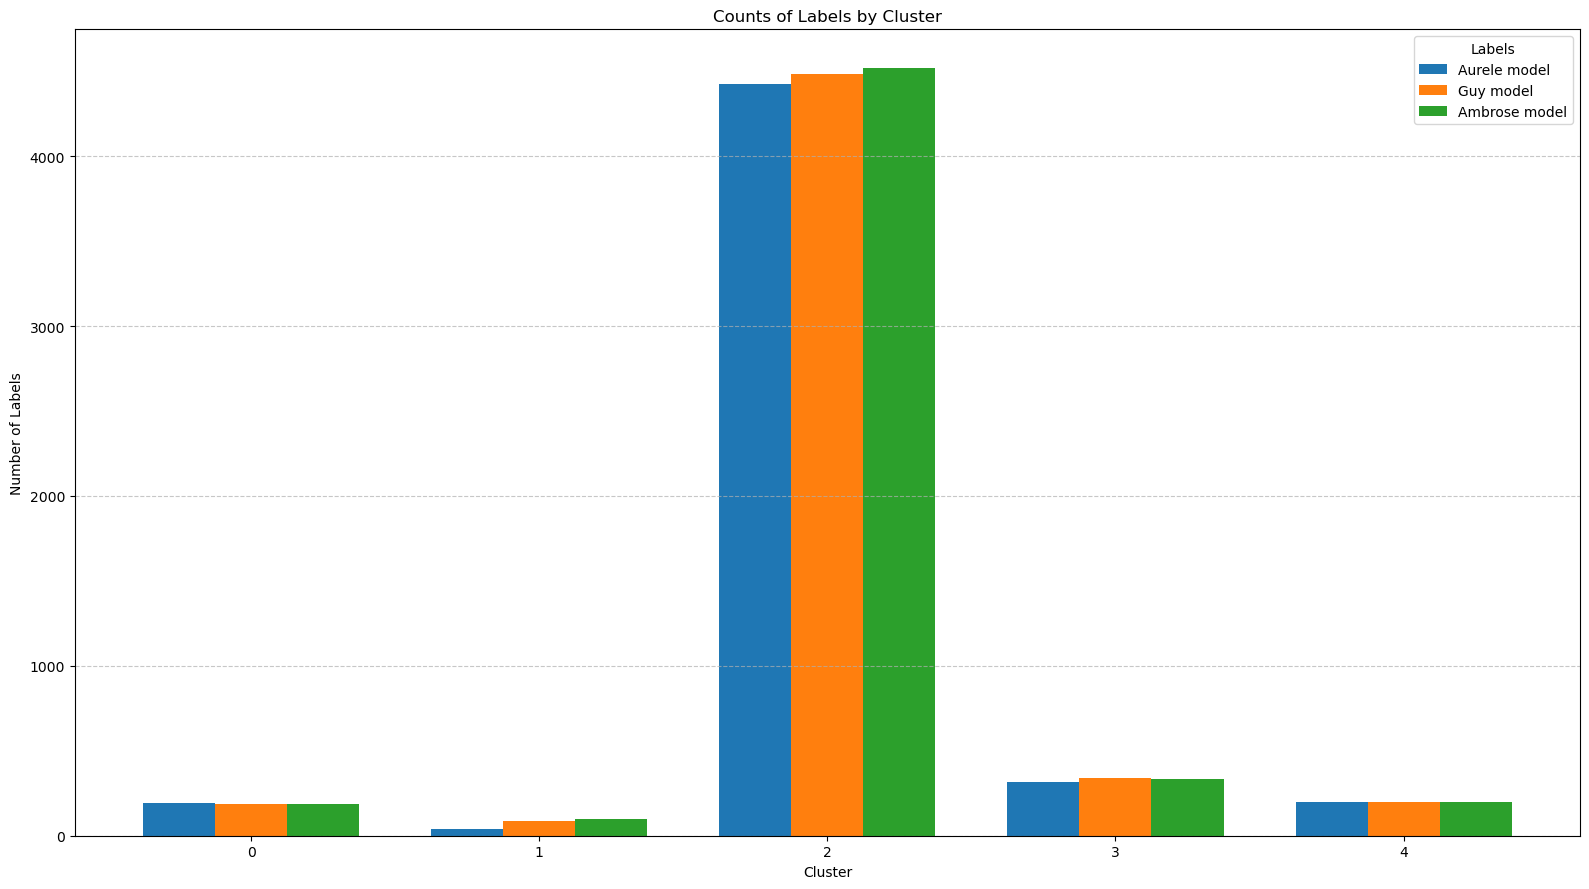

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Group by cluster and sum the labels
grouped_data = df.groupby('cluster')[['Aurele model', 'Guy model', 'Ambrose model']].sum()

# Set up the bar positions
clusters = grouped_data.index
labels = grouped_data.columns
x = np.arange(len(clusters))  # the label locations
width = 0.25  # the width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 9))

# Plot each label as a separate bar
for i, label in enumerate(labels):
    ax.bar(x + i * width, grouped_data[label], width, label=label)

# Customize the plot
ax.set_title('Counts of Labels by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Labels')
ax.set_xticks(x + width)  # Set the x-ticks to the middle of the grouped bars
ax.set_xticklabels(clusters)
ax.legend(title='Labels')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


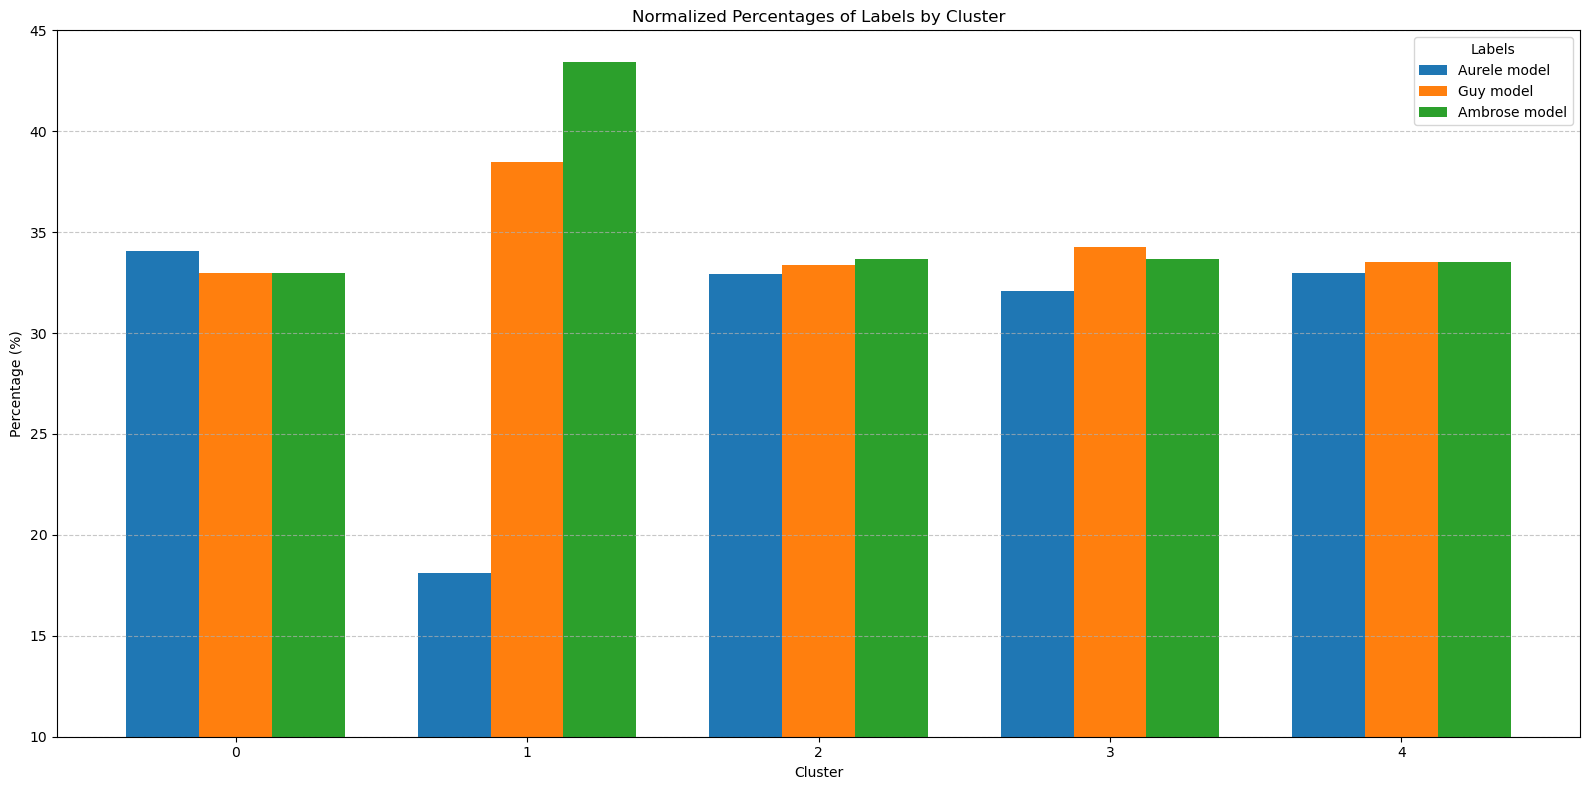

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Group by cluster and sum the labels
grouped_data = df.groupby('cluster')[['Aurele model', 'Guy model', 'Ambrose model']].sum()

# Normalize the data to percentages
normalized_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Set up the bar positions
clusters = normalized_data.index
labels = normalized_data.columns
x = np.arange(len(clusters))  # the label locations
width = 0.25  # the width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Plot each label as a separate bar (normalized percentages)
for i, label in enumerate(labels):
    ax.bar(x + i * width, normalized_data[label], width, label=label)

# Customize the plot
ax.set_title('Normalized Percentages of Labels by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(x + width)  # Set the x-ticks to the middle of the grouped bars
ax.set_xticklabels(clusters)
ax.legend(title='Labels')
ax.set_ylim(10, 45)  # Set y-axis range to 0–25%
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


## Differential analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a DataFrame with cluster assignments
df['cluster'] = kmeans.labels_

# Extract the unique terms for each cluster
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['clean_title'])

# Convert TF-IDF to a DataFrame for easier analysis
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['cluster'] = df['cluster']

# Identify the top terms for each cluster
top_terms = {}
for cluster in sorted(df['cluster'].unique()):
    cluster_terms = tfidf_df[tfidf_df['cluster'] == cluster].drop('cluster', axis=1).mean().sort_values(ascending=False)
    top_terms[cluster] = cluster_terms.head(10).index.tolist()  # Top 10 terms

# Print the distinctive terms per cluster
for cluster, terms in top_terms.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")


Cluster 0: russia, syria, say, korea, north, putin, war, iran, lavrov, deal
Cluster 1: boiler, room, ep, social, medium, great, reject, loss, book, life
Cluster 2: video, say, hillary, new, police, north, eu, korea, state, obama
Cluster 3: trump, video, president, supporter, donald, say, korea, north, hillary, medium


In [ ]:
# Compare term importance across clusters
for cluster, terms in top_terms.items():
    print(f"Cluster {cluster}:")
    for term in terms:
        term_mean_in_cluster = tfidf_df[tfidf_df['cluster'] == cluster][term].mean()
        term_mean_overall = tfidf_df[term].mean()
        print(f"  {term}: In cluster = {term_mean_in_cluster:.4f}, Overall = {term_mean_overall:.4f}")


Cluster 0:
  russia: In cluster = 0.3887, Overall = 0.0085
  syria: In cluster = 0.0696, Overall = 0.0082
  say: In cluster = 0.0514, Overall = 0.0237
  korea: In cluster = 0.0462, Overall = 0.0129
  north: In cluster = 0.0417, Overall = 0.0128
  putin: In cluster = 0.0369, Overall = 0.0037
  war: In cluster = 0.0312, Overall = 0.0083
  iran: In cluster = 0.0295, Overall = 0.0082
  lavrov: In cluster = 0.0248, Overall = 0.0009
  deal: In cluster = 0.0247, Overall = 0.0072
Cluster 1:
  boiler: In cluster = 0.5094, Overall = 0.0097
  room: In cluster = 0.5036, Overall = 0.0100
  ep: In cluster = 0.3408, Overall = 0.0073
  social: In cluster = 0.0196, Overall = 0.0027
  medium: In cluster = 0.0182, Overall = 0.0085
  great: In cluster = 0.0172, Overall = 0.0016
  reject: In cluster = 0.0153, Overall = 0.0021
  loss: In cluster = 0.0145, Overall = 0.0009
  book: In cluster = 0.0132, Overall = 0.0013
  life: In cluster = 0.0123, Overall = 0.0039
Cluster 2:
  video: In cluster = 0.0273, Over

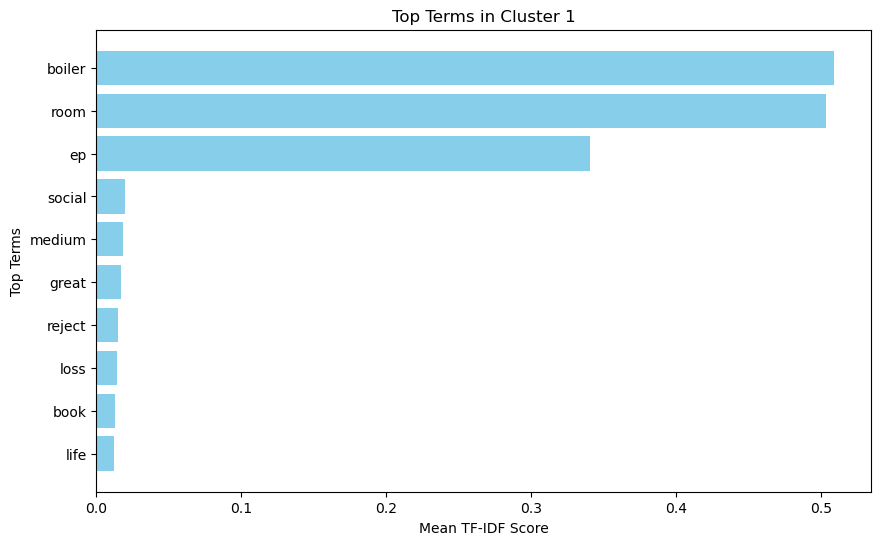

In [ ]:
import matplotlib.pyplot as plt

# Plot top terms for a specific cluster
cluster_to_plot = 1  # Change this to the cluster number you want to analyze
terms_to_plot = top_terms[cluster_to_plot]
term_means = [tfidf_df[tfidf_df['cluster'] == cluster_to_plot][term].mean() for term in terms_to_plot]

plt.figure(figsize=(10, 6))
plt.barh(terms_to_plot, term_means, color='skyblue')
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Top Terms')
plt.title(f'Top Terms in Cluster {cluster_to_plot}')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()
